# Trajectory Generation

- Trajectory generation aims at creating motion sequences that ensure that ensure a smooth motion. Here is an example of linear robot motion:

![](ur10_linear.gif)

- However, for serial manipulators (e.g., industrial robots), linear Cartesian-space motion is not trivial to compute. 
- Linear motion is often computed by subdividing joint-space motion into smaller segments. But, joint-space motion is non-linear in Cartesian-space:

![](ur10_joint.gif)

- While this segmented pseudo-linear motion is not perfect, it is often adequate for most applications.
- The following example will demonstrate trajectory generation through joint-space segmentation.

## Helper Functions

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_poses(p):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs=p[:, 0, -1], ys=p[:, 1, -1], zs=p[:, 2, -1], marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(600, 700)
    ax.set_ylim(-160, -140)
    ax.set_zlim(750, 850)

    plt.locator_params(nbins=4)
    plt.tight_layout()

In [2]:
def compute_deviation(p):
    # compute deviation at joint-space midpoint
    p1 = p[0, :-1, -1]
    p2 = p[1, :-1, -1]
    p3 = p[2, :-1, -1]

    deviation = np.linalg.norm(np.cross(p2 - p1,
                                        p1 - p3)) / np.linalg.norm(p2 - p1)

    print(f'Deviation: {deviation:.5f}mm')

## Create Robot Object

In [3]:
from pybotics.predefined_models import ur10
from pybotics.robot import Robot

robot = Robot.from_parameters(ur10())

## Define Poses

- Given two poses, we want a linearized trajectory between the two.

In [4]:
import numpy as np
from pybotics.geometry import vector_2_matrix

poses = np.array([
    vector_2_matrix([600, -150, 800,
                     np.deg2rad(-90), 0,
                     np.deg2rad(-90)]),
    vector_2_matrix([700, -150, 800,
                     np.deg2rad(-90), 0,
                     np.deg2rad(-90)])
])

start_end_joints = [robot.ik(p) for p in poses]

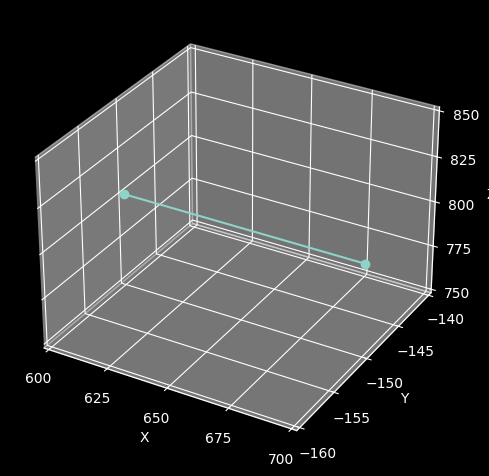

In [5]:
plot_poses(poses)

## Joint-space Trajectory

- Interestingly, the largest deviation in Cartesian-space will occur at the joint-space midpoint.

In [14]:
# compute joint-space midpoint
print(f"{poses=}")
print(f"{poses.shape=}")
joints = np.array([robot.ik(p, q=start_end_joints[0]) for p in poses])
print(f"{joints=}")
print(f"{joints.shape=}")

mid_joints = np.mean(joints, axis=0)
print(f"{mid_joints=}")
mid_pose = robot.fk(mid_joints)

deviated_poses = np.insert(arr=poses, obj=1, values=mid_pose, axis=0)

poses=array([[[ 6.12323400e-17,  6.12323400e-17,  1.00000000e+00,
          6.00000000e+02],
        [-1.00000000e+00,  3.74939946e-33,  6.12323400e-17,
         -1.50000000e+02],
        [ 0.00000000e+00, -1.00000000e+00,  6.12323400e-17,
          8.00000000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]],

       [[ 6.12323400e-17,  6.12323400e-17,  1.00000000e+00,
          7.00000000e+02],
        [-1.00000000e+00,  3.74939946e-33,  6.12323400e-17,
         -1.50000000e+02],
        [ 0.00000000e+00, -1.00000000e+00,  6.12323400e-17,
          8.00000000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]])
poses.shape=(2, 4, 4)
joints=array([[ 0.02748789, -1.51043176, -1.29950596,  2.80991939, -1.54330919,
         3.14159265],
       [ 0.02293636, -1.67632829, -1.12937233,  2.80573016, -1.5478595 ,
         3.14072621]])
joints.shape=(2, 6)
mid_joints=array([ 0.02521213, -1.59338003, -1.2144391

Deviation: 4.21157mm


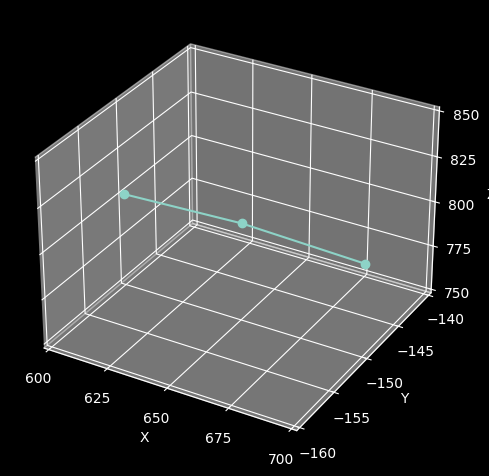

In [7]:
plot_poses(deviated_poses)
compute_deviation(deviated_poses)

## Segmented Linear Trajectory

In [8]:
# split linear trajectory in half, creating two joint-space segments
mid_cartesian_point = np.mean([poses[1, :-1, -1], poses[0, :-1, -1]], axis=0)

mid_pose = poses[0].copy()
mid_pose[:-1, -1] = mid_cartesian_point

segmented_poses = np.insert(arr=poses, obj=1, values=mid_pose, axis=0)

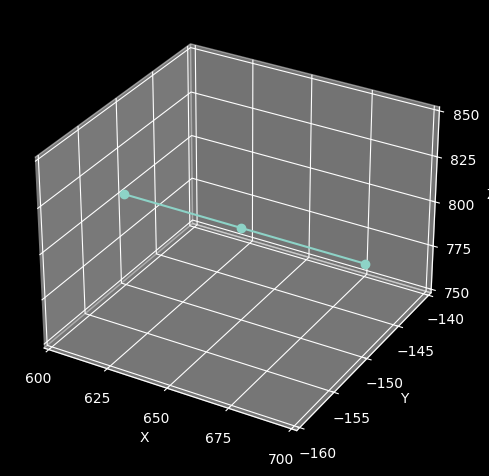

In [9]:
plot_poses(segmented_poses)

In [10]:
# compute joints for new trajectory
joints = [robot.ik(p, q=start_end_joints[0]) for p in segmented_poses]

# compute deviation for first segment
mid_joints = np.mean(joints[:2], axis=0)
first_mid_pose = robot.fk(mid_joints)
first_segmented_poses = np.insert(arr=poses,
                                  obj=1,
                                  values=first_mid_pose,
                                  axis=0)
compute_deviation(first_segmented_poses)

# compute deviation for second segment
mid_joints = np.mean(joints[1:], axis=0)
second_mid_pose = robot.fk(mid_joints)
second_segmented_poses = np.insert(arr=poses,
                                   obj=1,
                                   values=second_mid_pose,
                                   axis=0)
compute_deviation(second_segmented_poses)

Deviation: 2.04609mm
Deviation: 0.72488mm
